# Twitter Emoji Prediction Project

Github project: https://github.com/aparnnaH/Twitter-Emoji-Prediction-Project 

Video Link: https://youtu.be/ONjcuhJCyF4?si=QUwlnXrXgJQYWOoL

This project uses the Twitter Emoji Prediction dataset from Kaggle, which consists of tweets paired with emojis that reflect the context or sentiment of each post. Although the precise data collection method is not specified, the dataset was likely gathered using the Twitter API and preprocessed to emphasize the relationship between tweet text and emoji labels. It captures informal language, slang, and typical emoji usage found on social media.

### Files used:
Dataset: https://www.kaggle.com/datasets/hariharasudhanas/twitter-emoji-prediction/data?select=Train.csv 
- train.csv: for model training and validation
- test.csv: for final evaluation on unseen data
- Mapping.csv: provides the mapping between emoji symbols and their numeric labels

This dataset is well-suited for training deep learning models that predict the most appropriate emoji for a given tweet.

### Identifying a Deep Learning Problem
This task is a multi-class text classification problem: given a tweet, predict the correct emoji from a fixed set of labels. To address this, three distinct deep learning architectures are explored, each implemented in a separate Jupyter notebook:
- LSTM: Captures sequential structure and temporal dependencies in the tweet text.
- GRU: A simpler alternative to LSTM with faster training while still modeling sequences effectively.
- TextCNN: Uses convolutional layers to extract local n-gram features and position-invariant text patterns.

The objective is to compare these models in terms of prediction accuracy, training time, and ability to generalize. The comparison aims to identify which architecture is best suited for predicting emojis based on short, informal text inputs like tweets.


# LSTM Model

In [3]:
# pip install wordcloud

In [6]:
# pip install emoji

In [14]:
import logging
import warnings
# Suppress matplotlib font_manager warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
# Also suppress UserWarnings related to fonts
warnings.filterwarnings("ignore", message="findfont: Font family 'Apple Color Emoji' not found.")

In [15]:
# Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from torchtext.data.utils import get_tokenizer
from wordcloud import WordCloud
from collections import Counter
import emoji
import re

2025-06-20 17:24:59.420310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Load the training dataset containing text and corresponding emoji labels
train = pd.read_csv("train.csv")

# Load the mapping file that maps numeric labels to actual emoticons
mapping = pd.read_csv('Mapping.csv')

# Create a dictionary to map numeric labels to their corresponding emoticons
# 'number' column contains label IDs, 'emoticons' column contains emoji strings
emoji_map = dict(zip(mapping["number"], mapping["emoticons"]))
inv_map = {v: k for k, v in emoji_map.items()}

In [13]:
train.head(4)

,Unnamed: 0,TEXT,Label
0,0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,2,Been friends since 7th grade. Look at us now w...,2
3,3,This is what it looks like when someone loves ...,3


In [10]:
test_data = pd.read_csv('Test.csv')
test_data.head(4)

,Unnamed: 0,id,TEXT
0,0,0,Thought this was cool...#Repost (get_repost)・・...
1,1,1,Happy 4th! Corte madera parade. #everytownusa ...
2,2,2,Luv. Or at least something close to it. @ Unio...
3,3,3,There's a slice of pie under that whipped crea...


## Preparing Text Data for Modeling

In [21]:
# Store original train data
train_org = train

# Clean Text Function
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove @mentions
    text = re.sub(r"@\w+", "", text)
    # Remove special characters except basic punctuation
    text = re.sub(r"[^\w\s.,!?]", "", text)
    # Normalize spaces and convert to lowercase
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

# Apply text cleaning to all entries in the TEXT column
train["TEXT"] = train["TEXT"].astype(str).apply(clean_text)

# Tokenize and encode
# Initialize a basic english tokenizer
tokenizer = get_tokenizer("basic_english")

# Tokenize each cleaned tweet
train["tokens"] = train["TEXT"].apply(tokenizer)

# Build vocabulary from all unique tokens
vocab = set(token for tokens in train.tokens for token in tokens)

# Assign an index to each token
vocab_dict = {word: idx + 2 for idx, word in enumerate(vocab)}
vocab_dict["<pad>"] = 0  # padding token
vocab_dict["<unk>"] = 1  # unknown token

# Function to encode tokens into indices using vocab_dict
def encode(tokens):
    return [vocab_dict.get(t, 1) for t in tokens]

# Apply encoding to each list of tokens
train["encoded"] = train["tokens"].apply(encode)

MAX_LEN = 50
def pad(seq):
    return seq[:MAX_LEN] + [0] * (MAX_LEN - len(seq))
    
train["padded"] = train["encoded"].apply(pad)

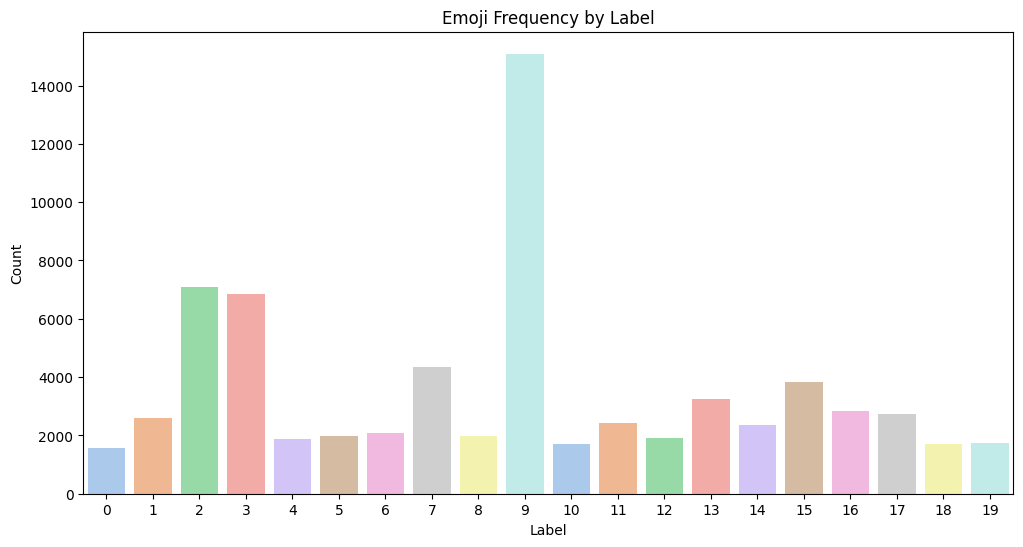

Emoji Label Mapping: 0: 😜, 1: 📸, 2: 😍, 3: 😂, 4: 😉, 5: 🎄, 6: 📷, 7: 🔥, 8: 😘, 9: ❤, 10: 😁, 11: 🇺🇸, 12: ☀, 13: ✨, 14: 💙, 15: 💕, 16: 😎, 17: 😊, 18: 💜, 19: 💯


In [22]:
# Plot emoji frequency with numeric labels
plt.figure(figsize=(12,6))
sns.countplot(x='Label', data=train, palette='pastel')
plt.title("Emoji Frequency by Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Legend mapping label to emoji
print("Emoji Label Mapping:", ', '.join([f"{label}: {emoji}" for label, emoji in emoji_map.items()]))

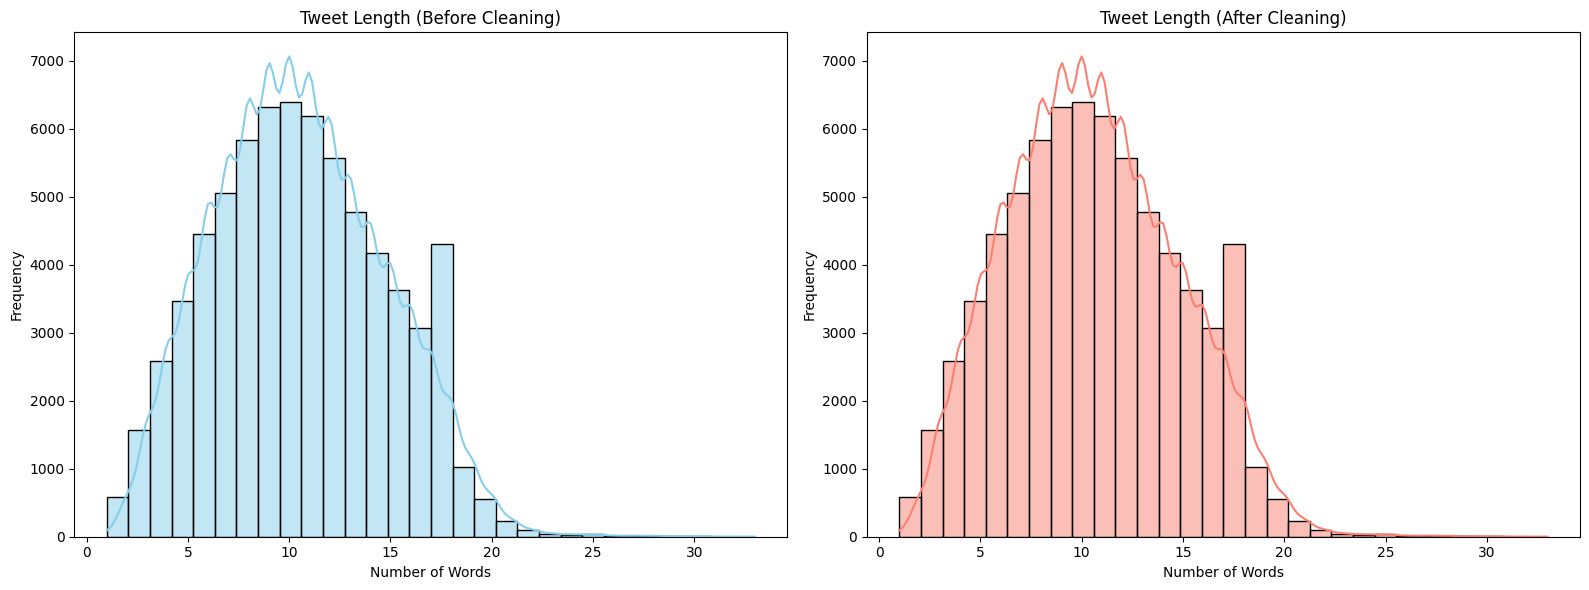

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate tweet lengths
train_org['text_length'] = train_org['TEXT'].apply(lambda x: len(str(x).split()))
train['text_length'] = train['TEXT'].apply(lambda x: len(str(x).split()))

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Before Cleaning
sns.histplot(train_org['text_length'], bins=30, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title("Tweet Length (Before Cleaning)")
axs[0].set_xlabel("Number of Words")
axs[0].set_ylabel("Frequency")

# After Cleaning
sns.histplot(train['text_length'], bins=30, kde=True, ax=axs[1], color='salmon')
axs[1].set_title("Tweet Length (After Cleaning)")
axs[1].set_xlabel("Number of Words")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

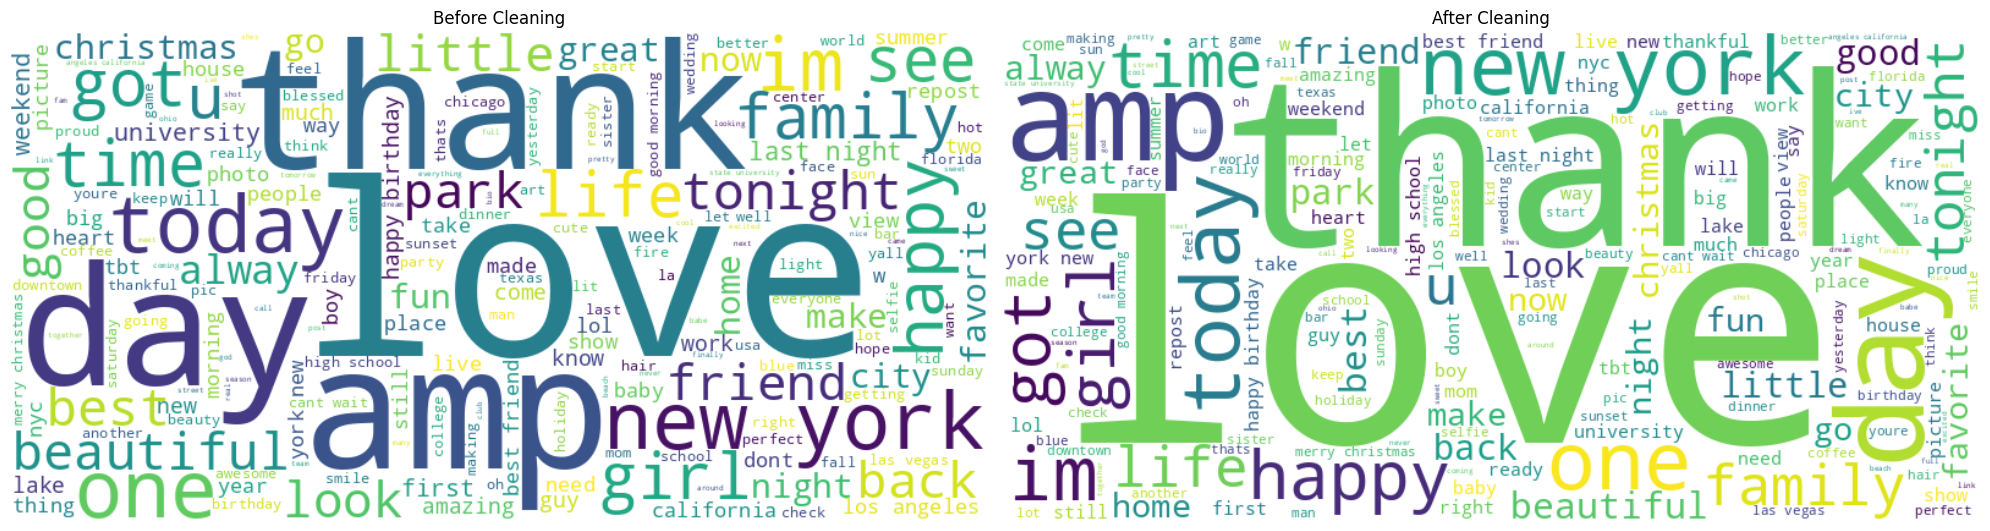

In [24]:
# Before cleaning
text_before = " ".join(train_org["TEXT"].astype(str))

# After cleaning
text_after = " ".join(train["TEXT"].astype(str))

# Create WordClouds
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(text_before)
wordcloud_after = WordCloud(width=800, height=400, background_color='white').generate(text_after)

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].imshow(wordcloud_before, interpolation='bilinear')
axs[0].axis("off")
axs[0].set_title("Before Cleaning")

axs[1].imshow(wordcloud_after, interpolation='bilinear')
axs[1].axis("off")
axs[1].set_title("After Cleaning")

plt.tight_layout()
plt.show()

## Building Dataset and DataLoader Objects

In [25]:
# Preprocessing
texts = train.TEXT.astype(str).tolist()
labels = train.Label.astype(int).tolist()
num_classes = len(set(labels))

max_words = 10000
max_len = 40

tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)
y = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

## Defining and Training the LSTM model

In [26]:
# Train and test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Model
model = Sequential([
    Embedding(max_words, 50, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128
)

Epoch 1/5
438/438 [==============================] - 15s 29ms/step - loss: 2.6329 - accuracy: 0.2407 - val_loss: 2.4484 - val_accuracy: 0.2922
Epoch 2/5
438/438 [==============================] - 13s 29ms/step - loss: 2.3398 - accuracy: 0.3195 - val_loss: 2.3754 - val_accuracy: 0.3124
Epoch 3/5
438/438 [==============================] - 13s 30ms/step - loss: 2.1771 - accuracy: 0.3576 - val_loss: 2.3635 - val_accuracy: 0.3204
Epoch 4/5
438/438 [==============================] - 14s 32ms/step - loss: 2.0384 - accuracy: 0.3924 - val_loss: 2.4042 - val_accuracy: 0.3178
Epoch 5/5
438/438 [==============================] - 13s 30ms/step - loss: 1.9156 - accuracy: 0.4278 - val_loss: 2.4792 - val_accuracy: 0.2968


The model's training accuracy improves steadily from 25% to 45%, showing it’s learning. However, validation accuracy only slightly improves, peaking around 34%. The gap between training and validation shows overfitting better on training data.

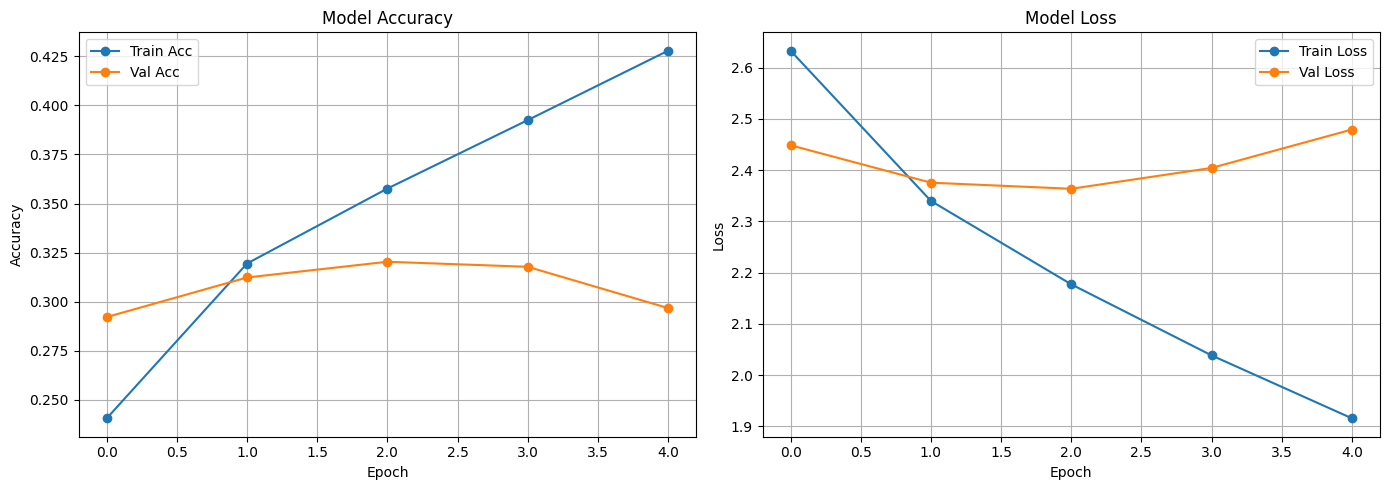

In [29]:
# Accuracy & Loss Plots
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluation

In [51]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(emoji_map.values())))

Classification Report:
              precision    recall  f1-score   support

           😜       0.00      0.00      0.00       282
           📸       0.22      0.26      0.24       531
           😍       0.22      0.28      0.25      1408
           😂       0.33      0.47      0.39      1384
           😉       0.07      0.01      0.01       372
           🎄       0.56      0.72      0.63       387
           📷       0.22      0.11      0.14       431
           🔥       0.37      0.45      0.41       875
           😘       0.25      0.01      0.02       377
           ❤       0.46      0.70      0.55      3049
           😁       0.00      0.00      0.00       355
          🇺🇸       0.43      0.54      0.48       509
           ☀       0.39      0.31      0.34       370
           ✨       0.19      0.21      0.20       644
           💙       0.24      0.04      0.07       466
           💕       0.16      0.06      0.09       728
           😎       0.13      0.20      0.16       587
    

The classification report reveals that while the model achieves a moderate accuracy of 34%, its performance varies widely across different emoji classes. Emojis like ❤️, 🎄, 🇺🇸, and 😂 are predicted with relatively high precision and recall, likely due to their strong, consistent contextual signals in the data. On the other hand, several emojis such as 😜, 😁, and 💜 show zero precision and recall, meaning the model failed to predict them altogether. This suggests issues with class imbalance, insufficient training examples, or overlapping usage contexts. The low macro F1-score of 0.20 highlights that many classes are underperforming. Overall, while the model captures common emojis fairly well, there's significant room for improvement in handling rarer or more ambiguous ones.

In [9]:
# Load the test dataset
test_data = pd.read_csv('Test.csv')
print(test_data.columns) # check column names

# Select the first 5 tweets
test_tweets = test_data['TEXT'].tolist()[:5]

# Predict emojis for each tweet and visualize the top 3 predictions
for tweet in test_tweets:
    pred = predict_emoji(tweet)
    # Get indices of top 3 predictions and probabilities
    top_indices = pred.argsort()[-3:][::-1]
    top_probs = [pred[i] for i in top_indices]

    # Print emoji predictions and confidence scores
    print("Top predicted emojis and confidence:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {emoji_map[idx]} — {top_probs[i]:.2f}")
    print("\n")

Thought this was cool...#Repost (get_repost)・・・Colorview. by shay_images…
Top predicted emojis and confidence: 
 1. 😎 — 0.35 
 2. 📸 — 0.13 
 3. 🔥 — 0.11

Happy 4th! Corte madera parade. #everytownusa #merica @ Perry's on…
Top predicted emojis and confidence: 
 1. 🇺🇸 — 0.99 
 2. ✨ — 0.00 
 3. 💙 — 0.00

Luv. Or at least something close to it. @ Union Hill, Richmond, Virginia
Top predicted emojis and confidence: 
 1. 😂 — 0.14 
 2. 😉 — 0.12 
 3. 💯 — 0.10


## Conculsion
The LSTM model performs well on tweets with clear and specific context, such as those mentioning holidays, food, or expressions of gratitude. It shows strong performance on structured language and can confidently predict emojis in cases like 🇺🇸 for a 4th of July tweet. However, it tends to struggle with tweets that contain slang, casual phrasing, or ambiguous meaning. While some predictions are precise, others include minor noise, though they often remain contextually relevant. Improving the model’s handling of informal language could lead to further gains in accuracy.